In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP,RxInfer,GraphPPL
using Random, Distributions, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets 
using KernelFunctions
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov

In [3]:
#Generate data 
Random.seed!(141)
function generate_data(n,σ_x,σ_y)
    x_prev = 0.
    latent_state = Vector{Float64}(undef, n)
    observation = Vector{Float64}(undef,n)
    for i=1:n
        latent_state[i] = transition_func(x_prev) + σ_x * randn()
        observation[i] = latent_state[i] + σ_y * randn() 
        x_prev = latent_state[i]
    end
    return latent_state, observation 
end

n = 100 #number of data 
σ_x = 1.
σ_y = 1.5
transition_func = (x) -> x + 0.1*sin(x)


#9 (generic function with 1 method)

In [4]:
true_state, data = generate_data(n,σ_x,σ_y);

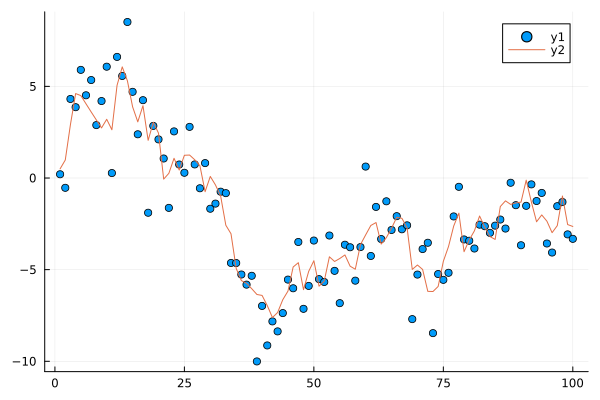

In [5]:
scatter(data)
plot!(true_state)

In [6]:
struct GPTransitionMeta{S,T,K}
    Xu          :: S
    Kuu_inverse :: T  
    Kuu         :: T
    kernel      :: K
end

GPTransitionMeta(Xu::Vector, Kuu_inverse::Matrix) = GPTransitionMeta(Xu, Kuu_inverse)
getinducinginput(meta::GPTransitionMeta) = meta.Xu 
getinverseKuu(meta::GPTransitionMeta) = meta.Kuu_inverse
getKuu(meta::GPTransitionMeta) = meta.Kuu 
getkernel(meta::GPTransitionMeta) = meta.kernel 
getparams(meta::GPTransitionMeta) = (meta.Xu, meta.Kuu, meta.Kuu_inverse)

getparams (generic function with 1 method)

In [7]:
function ReactiveMP.approximate_kernel_expectation(method::AbstractApproximationMethod, g::Function, m::Real, P::Real)

    weights = ReactiveMP.getweights(method, m, P)
    points  = ReactiveMP.getpoints(method, m, P)

    gbar = g(m) - g(m)
    foreach(zip(weights, points)) do (weight, point)
        gbar += weight * g(point)
    end

    return gbar
end

In [8]:
#create gp transition node 
struct GPTransition end 

@node GPTransition Stochastic [ out, in, u , γ] ## out: x_t , in: x_{t-1},  u: inducing points , γ: process noise 

@rule GPTransition(:out, Marginalisation) (q_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    Q = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    Kuu_inverse = getinverseKuu(meta)
    Xu = getinducinginput(meta)
    kernel = getkernel(meta)
    μ_u = mean(q_u)
    kxu = (x) -> kernelmatrix(kernel, [x], Xu)
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121), kxu, q_in)
    return NormalMeanVariance((Ψ1 * Kuu_inverse * μ_u)[1], Q)
end

@rule GPTransition(:out, Marginalisation) (q_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin 
    Q = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    Kuu_inverse = getinverseKuu(meta)
    Xu = getinducinginput(meta)
    kernel = getkernel(meta)
    μ_u = mean(q_u)
    kxu = (x) -> kernelmatrix(kernel, [x], Xu)
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121), kxu, q_in)
    return NormalMeanVariance((Ψ1 * Kuu_inverse * μ_u)[1], Q)
end

@rule GPTransition(:in, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta) = begin
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> kernelmatrix(kernel, [x], Xu) * Kuu_inverse
    B = (x) -> kernelmatrix(kernel,[x],[x]) .- kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x])
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)

    log_backwardmess = (x) -> -0.5 * (B(x)[1]/σ² + v_y/σ² + tr(A(x)' * A(x) *Σ_u)/σ² + log(2π*σ²) + (μ_y - (A(x)*μ_u)[1])^2/σ²)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end

@rule GPTransition(:u, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateNormalDistributionsFamily, q_γ::GammaShapeRate,meta::GPTransitionMeta) = begin
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    μ_y = mean(q_out)
    Xu = getinducinginput(meta)
    Kuu = getKuu(meta)
    kernel = getkernel(meta)

    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + + 1e-12*I 

    μ_u = μ_y * Kuu * cholinv(Ψ2)*Ψ1'
    Σ_u = σ² * Kuu * cholinv(Ψ2) * Kuu 
    return MvNormalMeanCovariance(vcat(μ_u...), Σ_u)
end

@rule GPTransition(:γ, Marginalisation) (q_out::UnivariateGaussianDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily,q_u::MultivariateNormalDistributionsFamily,meta::GPTransitionMeta,) = begin
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + + 1e-12*I 
    
    A = μ_y^2 + v_y -2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] + tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 )
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    return GammaShapeRate(1.5, 0.5*(A + Ψ0))
end

@rule GPTransition(:in, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin 
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> kernelmatrix(kernel, [x], Xu) * Kuu_inverse
    B = (x) -> kernelmatrix(kernel,[x],[x]) .- kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x])
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)

    log_backwardmess = (x) -> -0.5 * (B(x)[1]/σ² + v_y/σ² + tr(A(x)' * A(x) *Σ_u)/σ² + log(2π*σ²) + (μ_y - (A(x)*μ_u)[1])^2/σ²)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end

@rule GPTransition(:u, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin 
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    μ_y = mean(q_out)
    Xu = getinducinginput(meta)
    Kuu = getKuu(meta)
    kernel = getkernel(meta)

    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + + 1e-12*I 

    μ_u = μ_y * Kuu * cholinv(Ψ2)*Ψ1'
    Σ_u = σ² * Kuu * cholinv(Ψ2) * Kuu 
    return MvNormalMeanCovariance(vcat(μ_u...), Σ_u)
end

@average_energy GPTransition (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + + 1e-12*I 
    
    U = 1/(2*σ²) * (Ψ0 - tr(Kuu_inverse*Ψ2)) + 0.5 * log(2π*σ²) + 0.5 * (μ_y^2 + v_y - 2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] 
            + tr( Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 ))
    return U 
end

@average_energy GPTransition (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + + 1e-12*I 

    U = 1/(2*σ²) * (kernelmatrix(kernel,[μ_y],[μ_y])[] - tr(Kuu_inverse*Ψ2)) + 0.5 * log(2π*σ²) + 0.5 * (μ_y^2 + v_y - 2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] 
            + tr( Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 ))
    return U 
end

In [40]:
@model function gpssm(n,Kuu)
    y = datavar(Float64,n)
    x = randomvar(n)

    u ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(1e5,1e-12)
    x0 ~ NormalMeanVariance(0, 50.)
    # βy ~ GammaShapeRate(0.01,0.01)
    x_prev = x0
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,w) where { q = MeanField() }  #mean-field assumption
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [44]:
#create prior information about GP 
Nu = 50; #number of inducing points 
Xu = range(-5,5;length=Nu);

mean_gp = (x) -> 0
kernel_gp   =  1*with_lengthscale(LinearKernel(),0.1) + 0.1*with_lengthscale(Matern32Kernel(),0.01)

Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = cholinv(Kuu);

In [45]:
@meta function gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp)
    GPTransition(x,u) -> GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp)
end



gpssm_meta (generic function with 1 method)

In [46]:
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    m,v = approximate_meancov(ghcubature(121),(x) -> exp(right.logpdf(x)),left)
    if v < 0 || isnan(v)
        @show right.logpdf.(collect(-5:0.1:5))
    end
    return NormalMeanVariance(m,v)
end

In [47]:
#run inference 
niter = 30;

infer_result = inference(
    model = gpssm(n,Kuu),
    iterations = niter,
    data = (y = data,),
    initmarginals = (u = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu), x = NormalMeanVariance(0,50),w = GammaShapeRate(10,1),),
    meta = gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp),
    returnvars = (x = KeepLast(), u = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
) 

Inference results:
  Posteriors       | available for (w, u, x)
  Free Energy:     | Real[3.70696e6, 3.67144e6, 3.68195e6, 3.69534e6, 3.70846e6, 3.72097e6, 3.73249e6, 3.74284e6, 3.75198e6, 3.75982e6  …  3.78914e6, 3.78954e6, 3.78983e6, 3.79005e6, 3.7902e6, 3.79031e6, 3.7904e6, 3.79046e6, 3.79051e6, 3.79054e6]


In [48]:
#get results
qu = infer_result.posteriors[:u]
qx = infer_result.posteriors[:x];
qw = infer_result.posteriors[:w]
# qβy = infer_result.posteriors[:βy];
;

In [49]:
mean(qw)

1.2743366302986028

In [50]:
true_u = transition_func.(Xu);

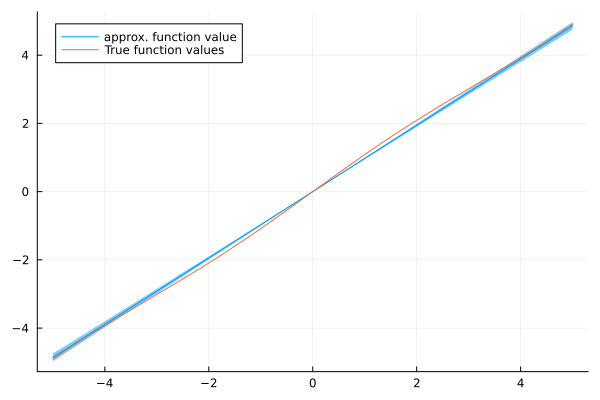

In [51]:
plot(Xu,mean(qu),ribbon = sqrt.(var(qu)),label="approx. function value")
plot!(Xu,true_u,label="True function values")

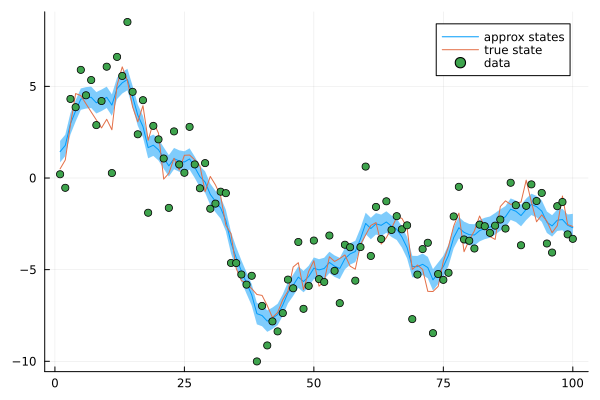

In [52]:
plot(mean.(qx), ribbon = sqrt.(var.(qx)),label="approx states")
plot!(true_state, label="true state")
scatter!(data,label="data")


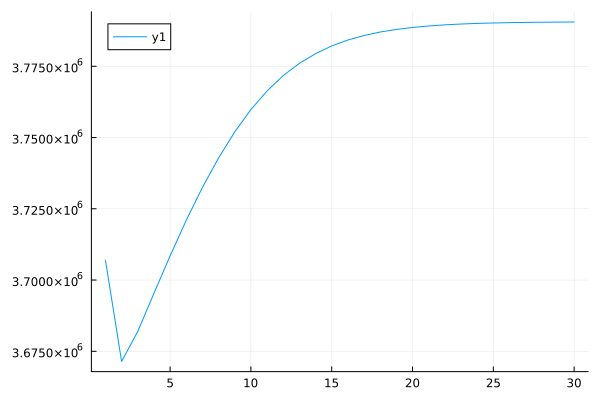

In [53]:
plot(infer_result.free_energy)

In [38]:
# function compute_f(x,u,Zu,Kuu_inverse,kernel)
#     kxu = kernelmatrix(kernel,[x],Zu)
#     return kxu*Kuu_inverse*u
# end


compute_f (generic function with 1 method)

In [39]:
# X = sort(mean.(qx));
# u = mean(qu);

# f_pos = [compute_f(i,u,Xu,Kuu_inverse,kernel_gp) for i in X]
# f_pos = vcat(f_pos...);

## compare vs unscented

In [54]:
#unscented transform knows the exact transition function
@model function ssm_unscented(n)
    y = datavar(Float64,n)
    x = randomvar(n)
    temp_transition = randomvar(n)

    # w ~ GammaShapeRate(1.,0.01)
    x0 ~ NormalMeanVariance(0, 50.)
    # βy ~ GammaShapeRate(0.01,0.01)
    x_prev = x0
    for i=1:n
        temp_transition[i] ~ transition_func(x_prev) where { meta = Unscented(alpha=0.01) }
        x[i] ~ NormalMeanVariance(temp_transition[i],σ_x^2) #where { q = MeanField() }
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [55]:
niter = 2
infer_result_UT = inference(
    model = ssm_unscented(n),
    iterations = niter,
    data = (y = data,),
    # initmessages = (x = NormalMeanVariance(0,1),),
    returnvars = (x = KeepLast(),),
    free_energy = true,
    showprogress = false
) 

Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[214.142, 214.142]


In [56]:

qx_UT = infer_result_UT.posteriors[:x]
# qw = infer_result_UT.posteriors[:w]
# qβy = infer_result_UT.posteriors[:βy];
;

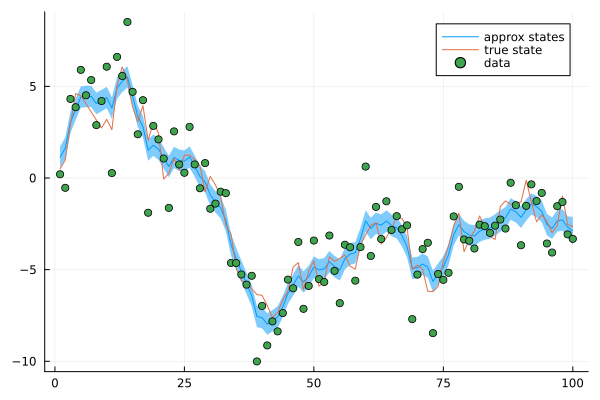

In [57]:
plot(mean.(qx_UT),ribbon=sqrt.(var.(qx)), label="approx states")
plot!(true_state, label="true state")
scatter!(data,label="data")

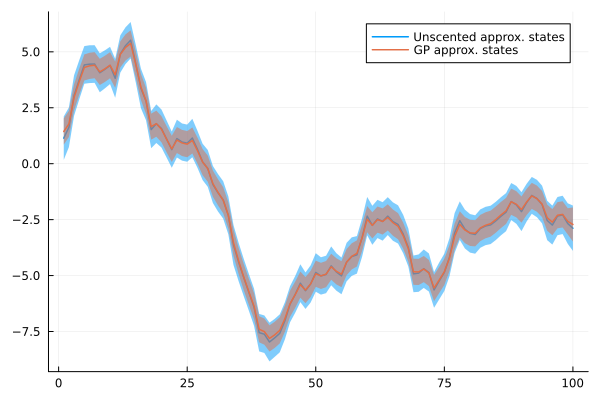

In [58]:
plot(mean.(qx_UT),ribbon=sqrt.(var.(qx_UT)), label="Unscented approx. states",lw=1.5)
plot!(mean.(qx), ribbon=sqrt.(var.(qx)), label="GP approx. states",lw=1.5)
# scatter!(data)